# Data Science - Poster Workshop

# How do different machine learning models compare in terms of performance for multivariate classification data?

We are using the Yeast dataset from:     

    Kenta Nakai
    Institue of Molecular and Cellular Biology
	Osaka, University
	1-3 Yamada-oka, Suita 565 Japan
    nakai@imcb.osaka-u.ac.jp
    http://www.imcb.osaka-u.ac.jp/nakai/psort.html
    Donor: Paul Horton (paulh@cs.berkeley.edu)
    Date:  September, 1996
    See also: ecoli database

This dataset is available here in the [UCI Archive](https://archive.ics.uci.edu/dataset/110/yeast)

For this data science poster workshop we will be exploring different classification methods and their performance.

First we will do some prepartion and exploration.
Then we will run differnt models with and without cross validation.
Finaly we will look at the results and draw some conclusions.

## Basic Data Preperation and Feature Engineering

In [171]:
# Imports
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [172]:
data = pd.read_csv("yeast/yeast.data", header=None, sep='\s+', engine='python')

data.columns = ["Sequence_Name", "mcg", "gvh", "alm", "mit", "erl", "pox", "vac", "nuc", "localization_site"]

The goal of this poster is to predict our target "localization_site" based on the 8 features given.

We will perform classification on using multiple different models and evaluate the performance of each model based on its accuracy and precision.

Finaly we will look at overall insights we can draw from this analysis.

localization_site
CYT    463
NUC    429
MIT    244
ME3    163
ME2     51
ME1     44
EXC     35
VAC     30
POX     20
ERL      5
Name: count, dtype: int64


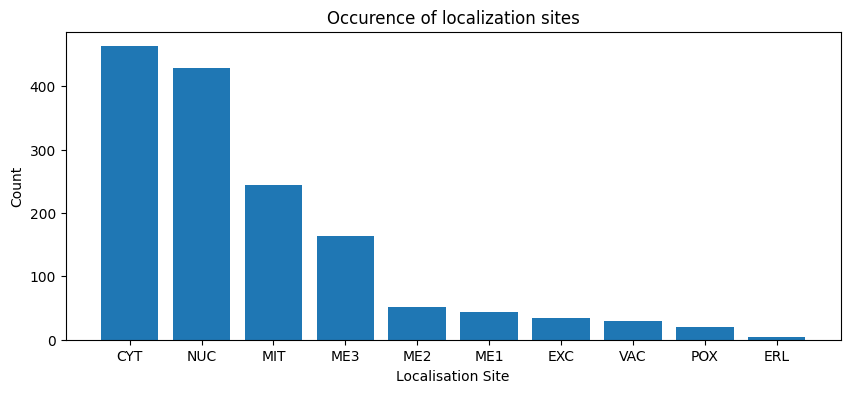

In [173]:
# The number of different occurences for each localization sites
print(data['localization_site'].value_counts())

# Setup localization_site as a category
data["localization_site"] = data["localization_site"].astype('category')

# Plot the occurence of localization sites
fig, ax = plt.subplots(figsize=(10, 4))
ax.set_ylabel('Count')
ax.set_xlabel('Localisation Site')
ax.set_title('Occurence of localization sites')
ax.bar(data['localization_site'].value_counts().index, data['localization_site'].value_counts().values)
plt.show()

We can see in the plot above the different amounts of localization sites in the whole dataset. This is a case of class imbalance. This could impact our later models and their performance.

## Analysis using different Models

In [174]:
# Preparing the data for training
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

X = data.iloc[:, 1:-1]
y = data.iloc[:, -1]

# Encoding the target variable into integers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

In [175]:
# Basic Models
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, classification_report
from sklearn.exceptions import UndefinedMetricWarning
from matplotlib.ticker import ScalarFormatter

models = []
models.append(('LR', 'Logistic Regression', LogisticRegression(max_iter=1000)))
models.append(('RFC', 'Random Forest Classifier', RandomForestClassifier(n_estimators=100, random_state=42)))
models.append(('GBC', 'Gradient Boosting Classifier', GradientBoostingClassifier()))
models.append(('MLP', 'Neural Network Classifier', MLPClassifier(hidden_layer_sizes=(100, 100), max_iter=1000)))
models.append(('SVC', 'Support Vector Classification', SVC()))

# evaluate each model in turn
results_accuracy = []
results_precision = []
names = []
names_full = []
for name, name_full, model in models:
    model.fit(X_train, y_train)
    model_predictions = model.predict(X_test)
    model_accuracy = accuracy_score(y_test, model_predictions)
    model_precision = precision_score(y_test, model_predictions, average='weighted')
    names.append(name)
    names_full.append(name_full)
    results_precision.append(model_precision)
    results_accuracy.append(model_accuracy)
    msg = "%s Precision: %f" % (name_full, model_precision)
    print(msg)

Logistic Regression Precision: 0.566594
Random Forest Classifier Precision: 0.614309
Gradient Boosting Classifier Precision: 0.591056
Neural Network Classifier Precision: 0.605660
Support Vector Classification Precision: 0.611017


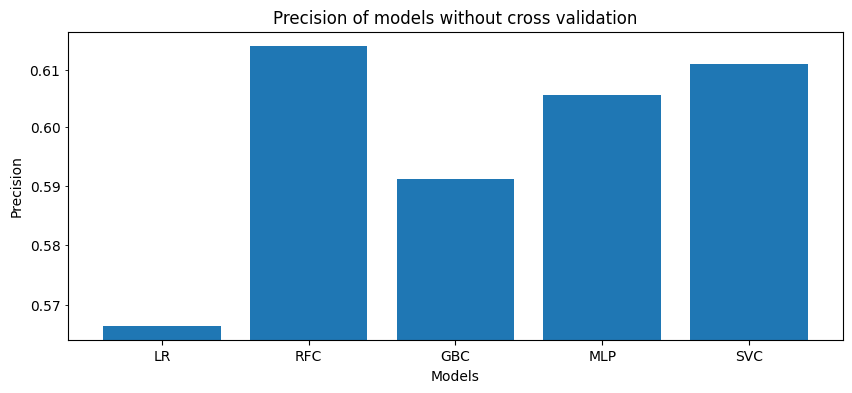

In [176]:
# Plot the occurence of localization sites
fig, ax = plt.subplots(figsize=(10, 4))
ax.set_ylabel('Precision')
ax.set_xlabel('Models')
ax.set_title('Precision of models without cross validation')
ax.bar(names, results_precision, log=True)
plt.gca().yaxis.set(major_formatter=ScalarFormatter(), minor_formatter=ScalarFormatter());
plt.show()

We see with the accuracy scores above we may have reached a certain threshold with our models.
We can further explore the limitation by using cross validation.

Using K-Fold Cross Validation shows us that most on the models (except for Logistic Regression) seems to yield quite similar accuracy.

In [177]:
# Accuracy of models  using cross validation
results = []
names = []
scoring = 'accuracy'
for name, name_full, model in models:
	kfold = model_selection.KFold(n_splits=4)
	cv_results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
	results.append(cv_results)
	names.append(name)
	msg = "%s Cross-Validation Accuracy: %f (%f)" % (name_full, cv_results.mean(), cv_results.std())
	print(msg)

Logistic Regression Cross-Validation Accuracy: 0.535780 (0.031363)
Random Forest Classifier Cross-Validation Accuracy: 0.609058 (0.046971)
Gradient Boosting Classifier Cross-Validation Accuracy: 0.590559 (0.019804)
Neural Network Classifier Cross-Validation Accuracy: 0.609066 (0.031566)
Support Vector Classification Cross-Validation Accuracy: 0.605711 (0.035278)


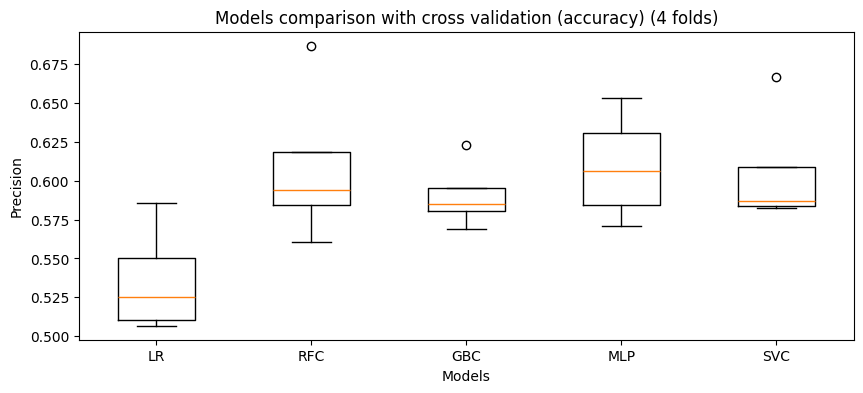

In [178]:
# boxplot comparison
fig, ax = plt.subplots(figsize=(10, 4))
ax.set_ylabel('Precision')
ax.set_xlabel('Models')
ax.set_title('Models comparison with cross validation (accuracy) (4 folds)')
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()